# HDDA F24 Recommendation systems via approximate matrix factorization

by Dmitry Beresnev (<d.beresnev@innopolis.university>)
and Vsevolod Klyushev (<v.klyushev@innopolis.university>)

Group ID = 1


In [1]:
from typing import Callable, Literal, Optional

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import sklearn
import tqdm
from scipy.sparse import csr_matrix
from sklearn.impute import SimpleImputer

## Utilities


In [3]:
def get_params_combinations(params: list[list]):
    if len(params) == 0:
        return [[]]
    return [(x, *k) for k in get_params_combinations(params[1:]) for x in params[0]]


def get_params_combinations_dict(possible_params_dict: dict[str, list]):
    if len(possible_params_dict) == 0:
        return [{}]
    dict_items = list(possible_params_dict.items())

    first_item = dict_items[0]

    if not isinstance(first_item[1], list):
        return [
            {first_item[0]: first_item[1], **k}
            for k in get_params_combinations_dict(dict(dict_items[1:]))
        ]

    return [
        {first_item[0]: x, **k}
        for k in get_params_combinations_dict(dict(dict_items[1:]))
        for x in first_item[1]
    ]

In [4]:
def rmse_score(
    initial_matrix: np.ndarray, predicted_matrix: np.ndarray, test_mask: np.ndarray
) -> float:
    differences = (initial_matrix[test_mask] - predicted_matrix[test_mask]) ** 2
    return np.sqrt(differences.mean()).item()

In [5]:
def choose_best(
    matrix: np.ndarray,
    mask: np.ndarray,
    solver: Callable,
    loss_fn: Callable[[np.ndarray], float],
    possible_params: dict,
) -> tuple[np.ndarray, float, dict, dict]:
    best_loss = 1e3
    best_solution = np.zeros(1)
    best_params = {}

    log_dicts = {}

    for params in get_params_combinations_dict(possible_params):
        solution, log_dict = solver(matrix, mask, **params)
        log_dicts[str(params)] = log_dict

        loss = loss_fn(solution)

        if loss < best_loss:
            best_loss = loss
            best_solution = solution.copy()
            best_params = params.copy()

    return best_solution, best_loss, best_params, log_dicts

In [6]:
def plot_log_dicts(log_dicts: dict, title: str):
    for name, log_dict in log_dicts.items():
        plt.plot(log_dict["iteration"], log_dict["objective"], label=name)

    plt.xlabel("Iteration")
    plt.ylabel("Objective, log")
    plt.legend(loc="lower left", bbox_to_anchor=(0, -0.3))
    plt.yscale("log")
    plt.title(title)
    plt.show()

In [7]:
def train_test_split_matrix(
    matrix: np.ndarray, mask: np.ndarray, test_percent: float, seed=420
) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    np.random.seed(seed)

    train_matrix = matrix.copy().flatten()
    train_mask = mask.copy().flatten()
    test_mask = np.zeros(mask.shape).astype(bool).flatten()

    existing_indices = np.argsort(~train_mask)[: np.sum(train_mask)]
    test_indices = np.random.choice(
        existing_indices, int(existing_indices.shape[0] * test_percent), replace=False
    )

    train_matrix[test_indices] = 0.0
    train_mask[test_indices] = False
    test_mask[test_indices] = True

    matrix_shape = matrix.shape

    return train_matrix.reshape(matrix_shape), train_mask.reshape(
        matrix_shape
    ), test_mask.reshape(matrix_shape)

## Data loading


### Toy data


In [8]:
toy_matrix_full = np.array(
    [
        [2, 3, 2, 0, 0],
        [0, 2, 0, 4, 3],
        [3, 0, 3, 0, 4],
        [0, 3, 0, 4, 3],
        [0, 0, 0, 0, 2],
        [1, 4, 3, 4, 0],
    ]
)  # 0  for unknown

toy_mask_full = toy_matrix_full != 0

In [9]:
toy_matrix, toy_mask, toy_test_mask = train_test_split_matrix(
    toy_matrix_full, toy_mask_full, test_percent=0.2
)

### Real data


In [10]:
def load_real_data() -> tuple[np.ndarray, np.ndarray]:
    data = scipy.io.loadmat("./data/Data/matlab/inputX.mat")
    x = csr_matrix(data["X"]).toarray()
    mask = x != 0
    return x, mask


real_matrix_full, real_mask_full = load_real_data()

In [11]:
real_matrix, real_mask, real_test_mask = train_test_split_matrix(
    real_matrix_full, real_mask_full, test_percent=0.01
)

print(f"Test size: {int(real_test_mask.sum())}")

Test size: 8001


## Test real data


In [12]:
def load_real_test_flatten_indices(real_matrix_shape: tuple) -> np.ndarray:
    data = scipy.io.loadmat("./data/Data/matlab/inputEval.mat")
    x = data["Eval"]
    rows_indices = x[:, 0] - 1
    columns_indices = x[:, 1] - 1
    return rows_indices * real_matrix_shape[0] + columns_indices


real_test_flatten_indices = load_real_test_flatten_indices(real_matrix.shape)
real_test_flatten_indices

array([  593,  3104,  1544, ..., 40305, 39553, 39565], dtype=uint16)

In [13]:
def save_solution(
    matrix: np.ndarray,
    test_flatten_indices: np.ndarray = real_test_flatten_indices,
    prefix: str = "",
    decimals: int = 4,
):
    predictions = np.round(matrix.flatten()[test_flatten_indices], decimals=decimals)
    results = pd.DataFrame(
        predictions, columns=["Rating"], index=np.arange(1, predictions.shape[0] + 1)
    )
    results.to_csv(f"./solutions/{prefix}submission.csv", index_label="ID")

## Block coordinate descent


In [ ]:
class Optimizer:
    def step(self, x: np.ndarray, grad: np.ndarray, lr: float, k: int) -> np.ndarray:
        raise NotImplementedError


class GradientDescent(Optimizer):
    def step(self, x: np.ndarray, grad: np.ndarray, lr: float, k: int) -> np.ndarray:
        return x - lr * grad


class Nesterov(Optimizer):
    def __init__(self, beta: float = 0.99):
        self.beta = beta

    def step(self, x: np.ndarray, grad: np.ndarray, lr: float, k: int) -> np.ndarray:
        if k == 0:
            self.h = grad.copy()
        else:
            self.h = self.beta * self.h_prev + grad
        g = grad + self.beta * self.h
        self.h_prev = self.h.copy()
        return x - lr * g

In [1]:
def init_gd(
    matrix: np.ndarray,
    mask: np.ndarray,
    rank: int,
    strategy: Literal["random", "svd", "mean"],
) -> tuple[np.ndarray, np.ndarray]:
    m, n = matrix.shape
    new_matrix = matrix.copy()

    if strategy == "random":
        return np.random.random((m, rank)), np.random.random((rank, n))

    if strategy == "mean":
        new_matrix = SimpleImputer(
            strategy=strategy, missing_values=0, keep_empty_features=True
        ).fit_transform(new_matrix)

    u, s, vt = sklearn.utils.extmath.randomized_svd(
        new_matrix, n_iter=25, n_components=rank
    )
    # u, s, vt = np.linalg.svd(new_matrix)
    # u = u[:,:rank]
    # v = vt[:,:rank]
    v = vt

    return u.astype(np.float64), v.astype(np.float64)


def objective_gd(
    matrix: np.ndarray,
    mask: np.ndarray,
    u: np.ndarray,
    v: np.ndarray,
    regularization: float = 0.0,
) -> float:
    n = np.sum(mask)

    return (
        (np.sum(mask * np.pow((matrix - (u @ v)), 2))) / n
        # + regularization * (np.linalg.norm(u) ** 2 + np.linalg.norm(v) ** 2)
    ).item()


def nabla_objective_gd(
    matrix: np.ndarray,
    mask: np.ndarray,
    u: np.ndarray,
    v: np.ndarray,
    for_v: bool = False,
    regularization: float = 0.0,
) -> np.ndarray:
    n = np.sum(mask)
    val = -2 / n * mask * (matrix - (u @ v))

    if for_v:
        return u.T @ val + 2 * regularization * v
    return val @ v.T + 2 * regularization * u


def tune_step(x: np.ndarray, grad_f, objective, optimizer: Optimizer, k, prev_step):
    step = prev_step
    e0 = objective(x)
    new_x = optimizer.step(x, grad_f(x), step, k)
    i = 0
    while objective(new_x) > e0:
        step = step / 2
        new_x = optimizer.step(x, grad_f(x), step, k)
        i += 1
        if i > 10:
            step = 1e-5
            optimizer.step(x, grad_f(x), step, k)
            break

    step *= 8
    return new_x, step


def adaptive_step(
    x: np.ndarray, grad, prev_grad, prev_x, prev_step, theta, start_step=0.0
):
    if prev_step is None:
        # step = 1e-10
        step = start_step
        theta = np.inf

        return step, theta
    step = prev_step
    if np.linalg.norm(prev_grad - grad) < 1e-5:
        min_value = np.sqrt(1 + theta) * step
    else:
        min_value = min(
            np.sqrt(1 + theta) * step,
            np.linalg.norm(x - prev_x) / (2 * np.linalg.norm(prev_grad - grad)),
        )

    if min_value == np.inf:
        # if min_value >= 1e2 or min_value == np.inf:
        min_value = 0.001

    theta = min_value / step
    step = min_value
    return step, theta


def block_gd(
    initial_matrix: np.ndarray,
    mask: np.ndarray,
    rank: int | float,
    iterations: int,
    optimizer: Callable[[], Optimizer] = GradientDescent,
    lr: Callable[[int], float] | float = 1e-3,
    init_strategy: Literal["random", "svd"] = "svd",
    regularization: float = 0.0,
    verbose: bool = True,
    seed: int = 420,
) -> tuple[np.ndarray, dict]:
    np.random.seed(seed)

    r = int(min(initial_matrix.shape) * rank) if isinstance(rank, float) else rank

    # Initializing
    u, v = init_gd(initial_matrix, mask, r, strategy=init_strategy)

    matrix = initial_matrix.copy().astype(np.float64)
    log_dict = {
        "objective": [],
    }
    u_optim = optimizer()
    v_optim = optimizer()

    lr_func: Callable[[int], float] = (lambda _: lr) if isinstance(lr, float) else lr  # type: ignore

    stepu = lr_func(0)
    stepv = lr_func(0)

    # For adaprive
    # stepu = None
    # stepv = None

    thetau = 0
    thetav = 0

    prev_grad_u = 0
    prev_grad_v = 0

    prev_u = u.copy()
    prev_v = v.copy()

    with tqdm.tqdm(range(iterations), disable=not verbose) as loop:
        for k in loop:
            alpha_u = alpha_v = lr_func(k)

            # Adaptve Step
            # grad_u = nabla_objective_gd(matrix, mask, u, v, regularization=regularization)
            # stepu, thetau = adaptive_step(
            #     u, grad_u, prev_grad_u, prev_u, stepu, thetau, start_step=lr_func(0)
            # )
            # prev_grad_u = grad_u.copy()

            # prev_u = u.copy()
            # u = u_optim.step(u, grad_u, stepu, k)

            # grad_v = nabla_objective_gd(
            #     matrix, mask, u, v, for_v=True, regularization=regularization
            # )
            # stepv, thetav = adaptive_step(
            #     v, grad_v, prev_grad_v, prev_v, stepv, thetav, start_step=lr_func(0)
            # )
            # prev_grad_v = grad_v.copy()

            # prev_v = v.copy()
            # v = v_optim.step(v, grad_v, stepv, k)

            # Simple Rule
            u, stepu = tune_step(
                u,
                lambda x: nabla_objective_gd(
                    matrix, mask, x, v, regularization=regularization
                ),
                lambda x: objective_gd(matrix, mask, x, v, regularization=regularization),
                u_optim,
                k,
                stepu,
            )
            v, stepv = tune_step(
                v,
                lambda x: nabla_objective_gd(
                    matrix, mask, u, x, for_v=True, regularization=regularization
                ),
                lambda x: objective_gd(matrix, mask, u, x, regularization=regularization),
                v_optim,
                k,
                stepv,
            )

            # log
            objective = objective_gd(matrix, mask, u, v, regularization=regularization)
            log_dict["objective"].append(objective)
            if verbose:
                loop.set_postfix({"Objective": objective})

        log_dict["iteration"] = list(range(len(log_dict["objective"])))

        pred = np.clip(u @ v, 1, 5)
        return matrix + (~mask) * pred, log_dict

NameError: name 'np' is not defined

In [ ]:
gd_toy_res = choose_best(
    toy_matrix,
    toy_mask,
    block_gd,
    lambda sol: rmse_score(toy_matrix_full, sol, toy_test_mask),
    {
        "rank": 2,
        "iterations": 10,
        "init_strategy": "mean",
        "lr": 1e-2,
        "optimizer": GradientDescent,
        "verbose": True,
        "regularization": 0,
    },
)


gd_toy_res[:-1]

100%|██████████| 10/10 [00:00<00:00, 551.24it/s, Objective=0.09]


(array([[2.        , 3.        , 2.        , 3.74287967, 2.8507186 ],
        [1.        , 2.        , 2.28648499, 4.        , 1.00791164],
        [3.        , 2.49777932, 3.        , 3.89498534, 4.        ],
        [1.        , 3.        , 2.55605237, 4.        , 1.        ],
        [2.02457018, 1.        , 1.        , 1.        , 2.        ],
        [1.        , 2.8862948 , 3.        , 4.        , 2.23655524]]),
 1.7520231437362284,
 {'rank': 2,
  'iterations': 10,
  'init_strategy': 'mean',
  'lr': 0.01,
  'optimizer': __main__.GradientDescent,
  'verbose': True,
  'regularization': 0})

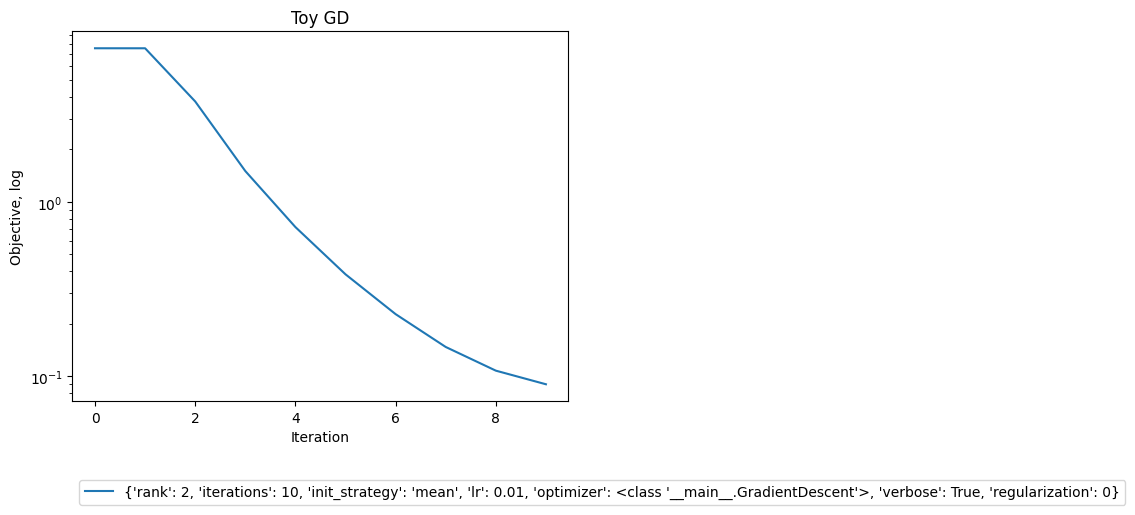

In [74]:
plot_log_dicts(gd_toy_res[-1], "Toy GD")

In [113]:
gd_res = choose_best(
    real_matrix,
    real_mask,
    block_gd,
    lambda sol: rmse_score(real_matrix_full, sol, real_test_mask),
    {
        "rank": 10,
        "iterations": 150,
        "init_strategy": "mean",
        "verbose": True,
        # "optimizer": lambda: Nesterov(0.9),
        # "lr": 1e-3,
        "optimizer": GradientDescent,
        "lr": 0.1,
        "regularization": 0.0,
    },
)

plot_log_dicts(gd_res[-1], "GD")

gd_res[:-1]

 21%|██▏       | 32/150 [05:22<19:48, 10.07s/it, Objective=0.829]


KeyboardInterrupt: 

In [ ]:
def fancy_block_gd(
    initial_matrix: np.ndarray,
    mask: np.ndarray,
    rank: int | float,
    iterations: int,
    optimizer: Callable[[], Optimizer] = GradientDescent,
    lr: Callable[[int], float] | float = 1e-3,
    init_strategy: Literal["random", "svd"] = "svd",
    regularization: float = 0.0,
    verbose: bool = True,
    seed: int = 420,
) -> tuple[np.ndarray, dict]:
    np.random.seed(seed)

    r = int(min(initial_matrix.shape) * rank) if isinstance(rank, float) else rank

    # Initializing
    u, v = init_gd(initial_matrix, mask, r, strategy=init_strategy)

    matrix = initial_matrix.copy().astype(np.float64)
    log_dict = {
        "objective": [],
    }
    u_optim = optimizer()
    v_optim = optimizer()

    lr_func: Callable[[int], float] = (lambda _: lr) if isinstance(lr, float) else lr  # type: ignore

    indices = [
        (i, j.item()) for i in range(mask.shape[0]) for j in np.where(mask[i, :])[0]
    ]
    with tqdm.tqdm(range(iterations), disable=not verbose) as loop:
        for k in loop:
            alpha_u = alpha_v = lr_func(k)

            # for i in range(matrix.shape[0]):
            #     indices = np.where(mask[i,:])[0]
            #     for j in indices:
            #         error_ij = matrix[i, j] - np.dot(u[i, :], v[:, j])
            #         grad_u = -2 * error_ij * v[:, j] + 2 * regularization * u[i, :]
            #         u[i, :] = u_optim.step(u[i, :], grad_u, alpha_u, k)

            # for j in range(matrix.shape[1]):
            #     indices = np.where(mask[:,j])[0]
            #     for i in indices:
            #         error_ij = matrix[i, j] - np.dot(u[i, :], v[:, j].T)
            #         grad_v = -2 * error_ij * u[i, :] + 2 * regularization * v[:, j]
            #         v[:, j] = v_optim.step(v[:, j], grad_v, alpha_v, k)

            np.random.shuffle(indices)
            for i, j in indices:
                error_ij = matrix[i, j] - np.dot(u[i, :], v[:, j].T)
                grad_v = -2 * error_ij * u[i, :] + 2 * regularization * v[:, j]
                v[:, j] = v_optim.step(v[:, j], grad_v, alpha_v, k)

                error_ij = matrix[i, j] - np.dot(u[i, :], v[:, j].T)
                grad_u = -2 * error_ij * v[:, j] + 2 * regularization * u[i, :]
                u[i, :] = u_optim.step(u[i, :], grad_u, alpha_u, k)

            # log
            objective = objective_gd(matrix, mask, u, v, regularization=regularization)
            log_dict["objective"].append(objective)
            if verbose:
                loop.set_postfix({"Objective": objective})

        log_dict["iteration"] = list(range(len(log_dict["objective"])))

        pred = np.clip(u @ v, 1, 5)
        return matrix + (~mask) * pred, log_dict

100%|██████████| 10/10 [02:15<00:00, 13.51s/it, Objective=0.767]


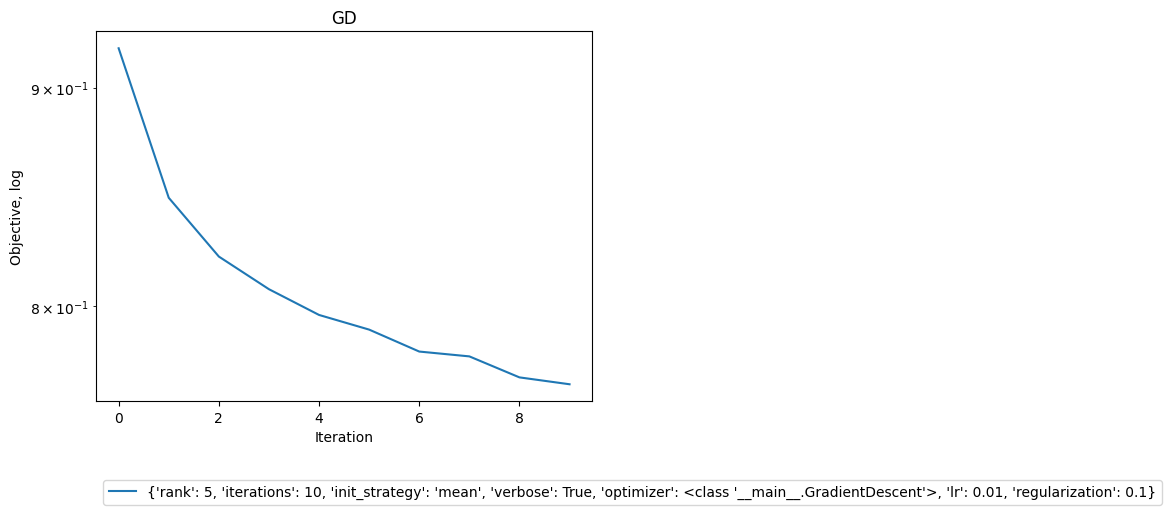

(array([[5.        , 3.14409792, 3.43205105, ..., 3.78672249, 4.14225647,
         4.1520849 ],
        [4.38865728, 3.05479252, 3.35130773, ..., 3.62204334, 3.91071015,
         3.96941726],
        [4.16868336, 2.99844357, 3.30752904, ..., 3.47477311, 3.75342643,
         3.82620595],
        ...,
        [4.16551443, 2.88184835, 3.12920319, ..., 3.49131421, 3.88269955,
         3.84642392],
        [3.90402786, 2.60922715, 2.83213318, ..., 3.26968541, 3.60685825,
         3.56609289],
        [3.        , 2.06624309, 2.12856458, ..., 3.23886578, 3.74176037,
         3.44440248]]),
 0.888247202457462,
 {'rank': 5,
  'iterations': 10,
  'init_strategy': 'mean',
  'verbose': True,
  'optimizer': __main__.GradientDescent,
  'lr': 0.01,
  'regularization': 0.1})

In [ ]:
gd_res = choose_best(
    real_matrix,
    real_mask,
    fancy_block_gd,
    lambda sol: rmse_score(real_matrix_full, sol, real_test_mask),
    {
        "rank": 5,
        "iterations": 10,
        "init_strategy": "mean",
        "verbose": True,
        "optimizer": GradientDescent,
        "lr": lambda k: 0.01 / np.sqrt(k + 1),
        # "lr": 0.01,
        # "lr": 0.01,
        "regularization": 0.1,
    },
)

plot_log_dicts(gd_res[-1], "GD")

gd_res[:-1]

In [140]:
save_solution(gd_res[0], decimals=5, prefix="gd")

## A1. SVD


In [ ]:
def impute(
    matrix: np.ndarray,
    mask: np.ndarray,
    strategy: Literal["mean", "most_frequent", "median", "random"],
) -> np.ndarray:
    if strategy in ["mean", "most_frequent", "median"]:
        return SimpleImputer(
            strategy=strategy, missing_values=0, keep_empty_features=True
        ).fit_transform(matrix)

    new_matrix = matrix.copy()
    new_matrix[~mask] = np.random.uniform(low=1, high=5, size=np.sum(~mask))
    return new_matrix


def svd_based(
    initial_matrix: np.ndarray,
    mask: np.ndarray,
    rank: int | float,
    iterations: int,
    imputing_strategy: Literal["mean", "most_frequent", "median", "random"] = "mean",
    randomized_svd: bool = False,
    verbose: bool = True,
    diff_norm_stopping_criterion: Optional[float] = None,
    seed: int = 420,
) -> tuple[np.ndarray, dict]:
    np.random.seed(seed)

    # Initial imputing
    matrix = impute(initial_matrix, mask, strategy=imputing_strategy)

    r = rank
    if isinstance(rank, float):
        r = int(min(matrix.shape) * rank)

    log_dict = {
        "objective": [],
    }

    with tqdm.tqdm(range(iterations), disable=not verbose) as loop:
        for _ in loop:
            old_matrix = matrix[~mask].copy()

            if randomized_svd:
                u, s, vt = sklearn.utils.extmath.randomized_svd(
                    matrix, n_components=r, random_state=seed
                )
                s = np.diag(s)

            else:
                u, s, vt = np.linalg.svd(matrix, full_matrices=False)
                s = np.diag(s[:r])
                u = u[:, :r]
                vt = vt[:r, :]

            matrix = u @ s @ vt

            # Keep known values
            matrix[mask] = initial_matrix[mask]

            # log
            diff_norm = np.linalg.norm(matrix[~mask] - old_matrix)
            log_dict["objective"].append(diff_norm)
            if verbose:
                loop.set_postfix({"Difference norm": diff_norm})

            if (
                diff_norm_stopping_criterion is not None
                and diff_norm <= diff_norm_stopping_criterion
            ):
                break

        log_dict["iteration"] = list(range(len(log_dict["objective"])))

        return matrix, log_dict

In [ ]:
svd_toy_res = choose_best(
    toy_matrix,
    toy_mask,
    svd_based,
    lambda sol: rmse_score(toy_matrix_full, sol, toy_test_mask),
    {
        "rank": [0.2, 0.3, 0.5],
        "iterations": 25,
        "imputing_strategy": ["mean", "most_frequent", "median", "random"],
        "randomized_svd": [True, False],
        "verbose": False,
    },
)

svd_toy_res[:-1]

(array([[2.        , 3.        , 2.        , 2.92431594, 2.68232072],
        [0.45829577, 2.        , 3.07384344, 4.        , 1.34197273],
        [3.        , 4.46710247, 3.        , 4.37030923, 4.        ],
        [1.55571574, 3.        , 2.91388923, 4.        , 2.45737367],
        [1.07604102, 2.61790234, 3.09133014, 4.13588594, 2.        ],
        [1.        , 2.49527507, 3.        , 4.        , 1.89301043]]),
 1.22157424565747,
 {'rank': 0.5,
  'iterations': 25,
  'imputing_strategy': 'most_frequent',
  'randomized_svd': False,
  'verbose': False})

In [ ]:
plot_log_dicts(svd_toy_res[-1], "Toy SVD")

In [ ]:
svd_res = choose_best(
    real_matrix,
    real_mask,
    svd_based,
    lambda sol: rmse_score(real_matrix_full, sol, real_test_mask),
    {
        "rank": 10,
        "iterations": 200,
        "imputing_strategy": "mean",
        "randomized_svd": True,
        "verbose": True,
    },
)

svd_res[:-1]

100%|██████████| 200/200 [03:45<00:00,  1.13s/it, Difference norm=3.65] 


(array([[5.        , 3.38652131, 3.24441599, ..., 3.69182739, 3.84242649,
         4.04154983],
        [4.03643502, 3.1162232 , 2.98546013, ..., 3.39716101, 3.53573991,
         3.71897005],
        [4.15777447, 3.20990011, 3.07520617, ..., 3.49928321, 3.64202794,
         3.83076616],
        ...,
        [3.86696185, 2.98538591, 2.86011304, ..., 3.2545283 , 3.38728886,
         3.56282592],
        [4.00175327, 3.08944806, 2.95980853, ..., 3.36797201, 3.50536022,
         3.68701601],
        [3.        , 2.9757912 , 2.85092094, ..., 3.2440686 , 3.37640248,
         3.55137538]]),
 2.646701411137743,
 {'rank': 1,
  'iterations': 200,
  'imputing_strategy': 'random',
  'randomized_svd': True,
  'verbose': True})

In [ ]:
plot_log_dicts(svd_res[-1], "SVD")

In [ ]:
save_solution(svd_res[0], decimals=5)